In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
import emcee
import corner

In [3]:
#%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [15]:
# read spec data
z = 0.0307
spec = '../spectroscopy/ZTF20aayhacx_20200529_Lick_3-m_v1.ascii'

spec_df = pd.read_csv(spec, comment='#', delim_whitespace=True, header=None)
wv = spec_df[0].values
wv_rf = wv / (1 + z)
fl = spec_df[1].values
fl_unc = spec_df[2].values

In [5]:
def divide_continuum(lambda_rf, flux, blue_continuum, red_continuum):
    '''Divide out linear continuum factor'''

    linear_continuum = lambda slope, wave, wave0, flux0: slope * (wave - wave0
                                                                  ) + flux0

    slope = (blue_continuum[1] - red_continuum[1]) / (blue_continuum[0] -
                                                      red_continuum[0])
    norm_flux = flux / linear_continuum(slope, lambda_rf, blue_continuum[0],
                                        blue_continuum[1])

    return norm_flux

In [6]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c*((lambda_rf/lambda_0)**2 - 1)/((lambda_rf/lambda_0)**2 + 1)
    
    return v

In [7]:
def calc_gauss(mean_vel, var_vel, amplitude, vel_rf):
    gauss = amplitude / np.sqrt(2 * np.pi * var_vel) * np.exp(
        -0.5 * (vel_rf - mean_vel)**2 / var_vel)
    return gauss

In [8]:
def flux_gauss(theta, vel_rf, delta_vel_components=[]):

    model_flux = np.ones_like(vel_rf)
    for i in range(len(theta) // 3):
        mean_vel, lnvar, amplitude = theta[3 * i:3 * i + 3]
        var_vel = np.exp(lnvar)
        model_flux += calc_gauss(mean_vel, var_vel, amplitude, vel_rf)

        if len(delta_vel_components) > 0:
            for delta_vel in delta_vel_components:
                model_flux += calc_gauss(mean_vel - delta_vel, var_vel,
                                         amplitude, vel_rf)
    return model_flux

In [9]:
def lnlike_gaussian_abs(theta,
                        vel_rf,
                        norm_flux,
                        delta_vel_components=[],
                        flux_unc=1,
                        type='gaussian'):
    model_flux = flux_gauss(theta, vel_rf, delta_vel_components)
    if type == 'gaussian':
        lnl = -0.5 * len(model_flux) * np.log(2 * np.pi) - np.sum(
            np.log(flux_unc)) - 0.5 * np.sum(
                (norm_flux - model_flux)**2 / flux_unc**2)
    elif type == 'chi2':
        lnl = -np.sum((norm_flux - model_flux)**2 / flux_unc**2)

    return lnl


def lnprior(theta, mu_pvf=-1e4, var_pvf=1e7):
    if len(theta) == 3:
        mean_vel, lnvar, amplitude = theta
        var_vel = np.exp(lnvar)
        if (-40000 < mean_vel < 0 and 100 < var_vel**0.5 < 22000
                and -1e5 < amplitude < 0):
            return 0  #-np.log(40000 * (22000 - 100) * 1e5)
        else:
            return -np.inf
    elif len(theta) == 6:
        mean_vel_pvf, lnvar_pvf, amp_pvf = theta[:3]
        mean_vel_hvf, lnvar_hvf, amp_hvf = theta[3:]
        var_rel_pvf = np.exp(lnvar_pvf)
        var_rel_hvf = np.exp(lnvar_hvf)

        lnpvf = -0.5 * np.log(
            2 * np.pi * var_pvf) - (mean_vel_pvf - mu_pvf)**2 / 2 / var_pvf

        if (0 > mean_vel_pvf > -2e4 and 1e5 < var_rel_pvf < 1e9
                and -1e4 < amp_pvf < 0
                and mean_vel_pvf - 2000 > mean_vel_hvf > -4e4
                and 1e5 < var_rel_hvf < 1e9 and -1e4 < amp_hvf < 0):
            lnflat = 0
        else:
            lnflat = -np.inf
        return lnpvf + lnflat


def ln_prob(theta,
            vel_rf,
            norm_flux,
            delta_vel_components=[],
            mu_pvf=-1e4,
            var_pvf=1e7,
            norm_flux_unc=1):
    ln_prior = lnprior(theta, mu_pvf=mu_pvf, var_pvf=var_pvf)
    ln_like = lnlike_gaussian_abs(theta, vel_rf, norm_flux,
                                  delta_vel_components, norm_flux_unc)
    return ln_prior + ln_like


def neg_lnlike_gaussian_abs(theta,
                            vel_rf,
                            norm_flux,
                            delta_vel_components=[],
                            flux_unc=1,
                            type='gaussian'):
    lnl = lnlike_gaussian_abs(theta,
                              vel_rf,
                              norm_flux,
                              delta_vel_components=delta_vel_components,
                              flux_unc=flux_unc,
                              type=type)
    return -1 * lnl

In [10]:
#define function to plot walker chains
def plotChains(sampler, nburn, paramsNames, nplot=None):
    '''Plot individual chains from the emcee MCMC sampler
    
    Parameters
    ----------
    sampler : emcee EnsembleSampler object
        emcee affine-invariant multi-chain MCMC sampler
    
    nburn : int
        number of "burn-in" steps for the MCMC chains
    
    paramsNames : list
        names of the parameters to be shown
    
    nplot : int (default=None)
        number of chains to show in the visualization.
        In instances where the number of chains is 
        very large (>> 100), then it can be helpful to 
        downsample to provide more clarity.
    
    Returns
    -------
    ax : maptlotlib axes object
        multi panel plot showing the evoltion of 
        each chain for the parameters in the model
    
    '''

    Nparams = len(paramsNames)
    nwalkers = sampler.get_chain().shape[1]

    fig, ax = plt.subplots(Nparams + 1,
                           1,
                           figsize=(12, 3 * (Nparams + 1)),
                           sharex=True)
    fig.subplots_adjust(hspace=0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    if nplot is None:
        nplot = nwalkers
    selected_walkers = np.random.choice(range(nwalkers), nplot, replace=False)
    for i, p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn],
                              sampler.get_chain()[:nburn, w, i],
                              alpha=0.4,
                              lw=0.7,
                              zorder=1)
            ax[i].plot(xplot[nburn:],
                       sampler.get_chain(discard=nburn)[:, w, i],
                       color=burn[0].get_color(),
                       alpha=0.8,
                       lw=0.7,
                       zorder=1)

            ax[i].set_ylabel(p)
            if i == Nparams - 1:
                ax[i + 1].plot(xplot[:nburn],
                               sampler.get_log_prob()[:nburn, w],
                               color=burn[0].get_color(),
                               alpha=0.4,
                               lw=0.7,
                               zorder=1)
                ax[i + 1].plot(xplot[nburn:],
                               sampler.get_log_prob(discard=nburn)[:, w],
                               color=burn[0].get_color(),
                               alpha=0.8,
                               lw=0.7,
                               zorder=1)
                ax[i + 1].set_ylabel('ln P')

    return ax

## Si II 6355

`velocity_rf(6371.359, 6347.103)`

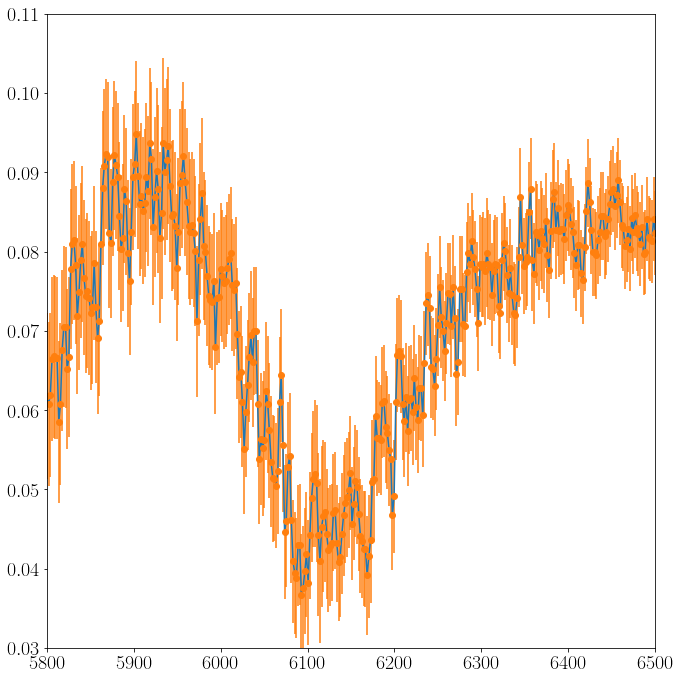

In [18]:
plt.figure(figsize=(10, 10))
plt.plot(wv / (1 + z), fl)
plt.errorbar(wv / (1 + z), fl, yerr=fl_unc, fmt='o')
plt.ylim(0.03, 0.11)
plt.xlim(5800, 6500)
plt.tight_layout()

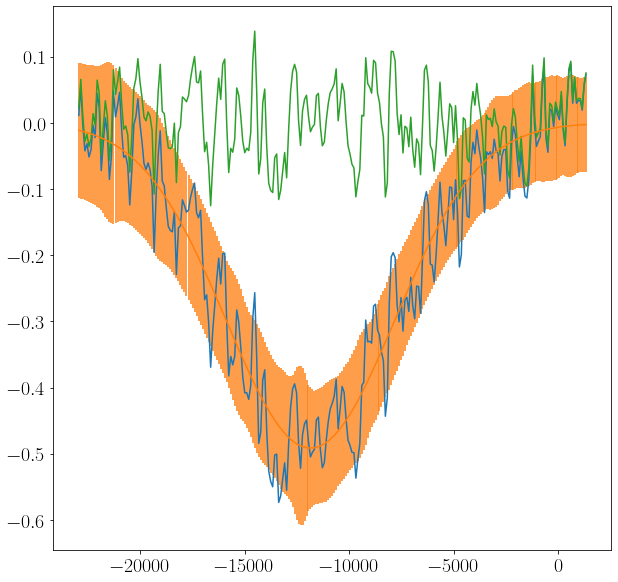

In [19]:
lambda_SiII = 6371.359
vel_rf = velocity_rf(wv_rf, lambda_SiII)
blue_edge = (5900, 0.09)
red_edge = (6400, 0.08)
line_region = np.where((wv / (1 + z) > blue_edge[0]) & (wv /
                                                        (1 + z) < red_edge[0]))
k = (blue_edge[1] - red_edge[1]) / (blue_edge[0] - red_edge[0])
b = red_edge[1] - k * red_edge[0]
norm_flux = fl / (k * wv_rf + b)
norm_flux_unc = fl_unc / (k * wv_rf + b)

ml_res = minimize(
    neg_lnlike_gaussian_abs,
    (-10000, 15, -1000),
    method='Powell',  # Powell method does not need derivatives
    args=(vel_rf[line_region], norm_flux[line_region],
          [velocity_rf(lambda_SiII, 6347.103)], norm_flux_unc[line_region], 'chi2'))

plt.figure(figsize=(10, 10))
plt.plot(vel_rf[line_region], norm_flux[line_region] - 1)
plt.errorbar(vel_rf[line_region],
             flux_gauss(ml_res['x'], vel_rf[line_region],
                        [velocity_rf(lambda_SiII, 6347.103)]) - 1,
             yerr=norm_flux_unc[line_region])
plt.plot(
    vel_rf[line_region],
    norm_flux[line_region] - flux_gauss(ml_res['x'], vel_rf[line_region],
                                        [velocity_rf(lambda_SiII, 6347.103)]))

In [20]:
ml_res

   direc: array([[-5.99129989e+02,  3.37724371e-01, -4.68718466e+02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 3.02684524e+01,  2.70136699e-03, -1.02065332e+01]])
     fun: 95.70370477985847
 message: 'Optimization terminated successfully.'
    nfev: 149
     nit: 4
  status: 0
 success: True
       x: array([-11294.22926995,     16.58585716,  -2486.35333916])

In [21]:
nwalkers = 50
ndim = 3
initial = np.array([-11294.22926995,     16.58585716,  -2486.35333916])
ndim = len(initial)
p0 = [i + initial for i in np.random.randn(nwalkers, ndim) * 1e-5]

In [22]:
paramsNames = ['Velocity pvf', 'ln($\sigma$) pvf', 'A pvf']
nburn = 200
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    ln_prob,
    args=(vel_rf[line_region], norm_flux[line_region], [
        velocity_rf(lambda_SiII, 6347.103),
    ], -1e4, 1e7, norm_flux_unc[line_region] *
          (ml_res['fun'] / len(line_region[0]))**.5))
sampler.run_mcmc(p0, 1500, progress=True)
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

100%|██████████| 1500/1500 [00:07<00:00, 200.89it/s]


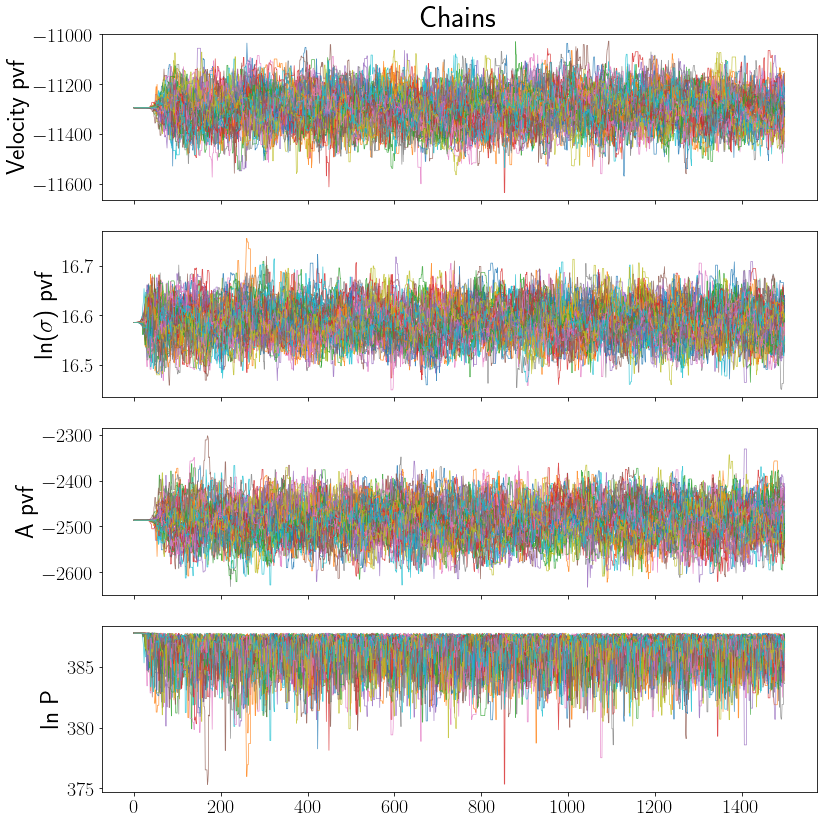

In [23]:
plotChains(sampler, 0, paramsNames)
plt.tight_layout()

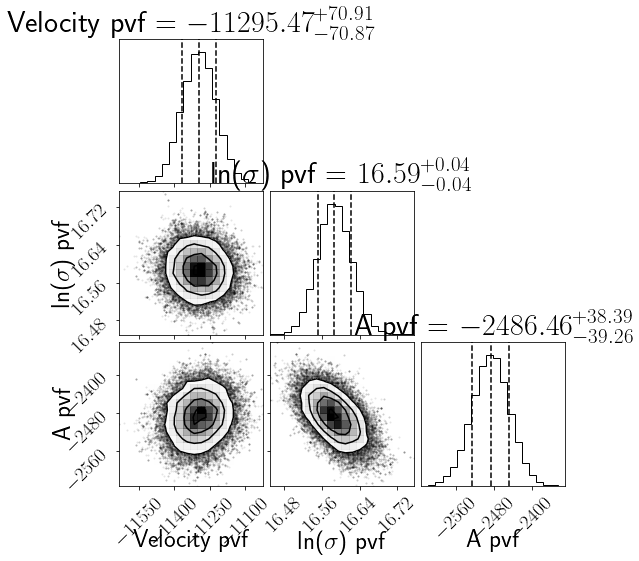

In [24]:
fig = corner.corner(samples,
                    labels=paramsNames,
                    quantiles=[0.16, 0.50, 0.84],
                    show_titles=True)

## Ca II IRT

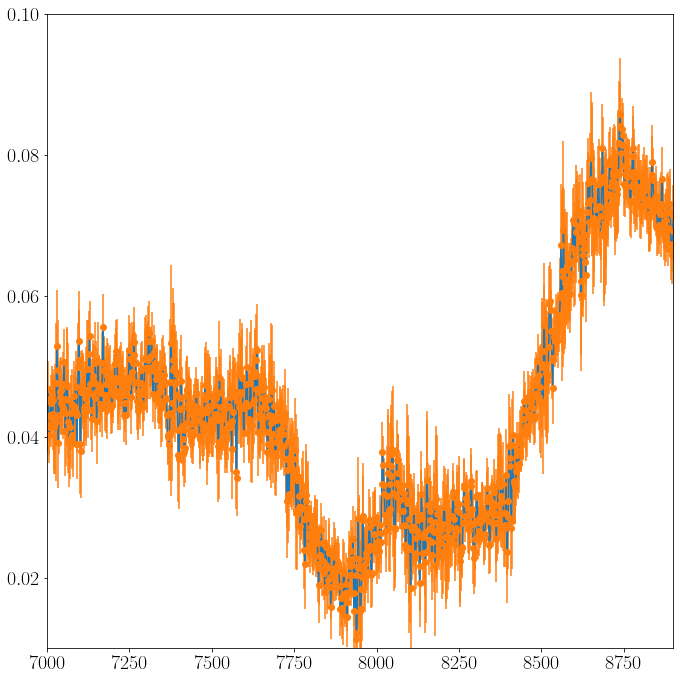

In [28]:
plt.figure(figsize=(10, 10))
plt.plot(wv_rf, fl)
plt.errorbar(wv_rf, fl, yerr=fl_unc, fmt='o')
plt.ylim(0.01, 0.10)
plt.xlim(7000, 8900)
plt.tight_layout()

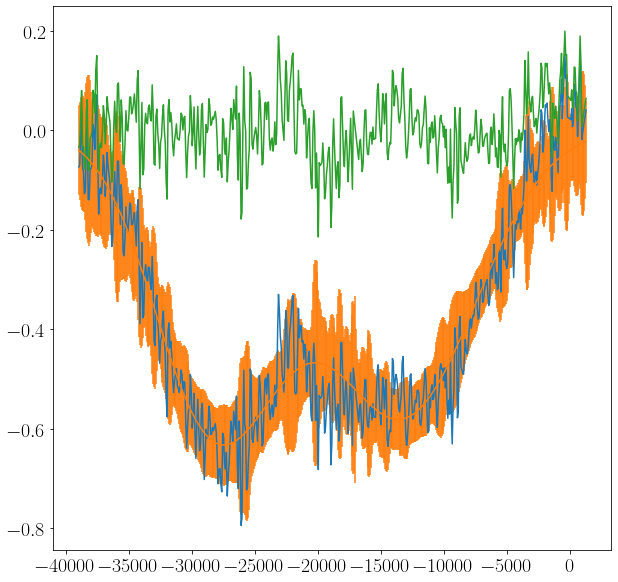

In [29]:
lambda_CaII_IRT = 8662.140
vel_rf = velocity_rf(wv_rf, lambda_CaII_IRT)
blue_edge = (7600, 0.048)
red_edge = (8700, 0.07)
line_region = np.where((wv / (1 + z) > blue_edge[0]) & (wv /
                                                        (1 + z) < red_edge[0]))
k = (blue_edge[1] - red_edge[1]) / (blue_edge[0] - red_edge[0])
b = red_edge[1] - k * red_edge[0]
norm_flux = fl / (k * wv_rf + b)
norm_flux_unc = fl_unc / (k * wv_rf + b)
thresh = 1e-3
norm_flux_unc[norm_flux_unc<thresh] = norm_flux_unc[norm_flux_unc>thresh].min()

ml_res = minimize(
    neg_lnlike_gaussian_abs,
    (-8200, 17.5, -3500, -20000, 15, -700),
    method='Powell',  # Powell method does not need derivatives
    args=(vel_rf[line_region], norm_flux[line_region], [
        velocity_rf(lambda_CaII_IRT, 8498.018),
        velocity_rf(lambda_CaII_IRT, 8542.089)
    ], norm_flux_unc[line_region], 'chi2'))

plt.figure(figsize=(10, 10))
plt.plot(vel_rf[line_region], norm_flux[line_region] - 1)
plt.errorbar(
    vel_rf[line_region],
    flux_gauss(ml_res['x'], vel_rf[line_region], [
        velocity_rf(lambda_CaII_IRT, 8498.018),
        velocity_rf(lambda_CaII_IRT, 8542.089)
    ]) - 1, yerr=norm_flux_unc[line_region])
plt.plot(
    vel_rf[line_region],
    norm_flux[line_region] - flux_gauss(ml_res['x'], vel_rf[line_region], [
        velocity_rf(lambda_CaII_IRT, 8498.018),
        velocity_rf(lambda_CaII_IRT, 8542.089)
    ]))

In [30]:
ml_res

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.36401964e+01,  2.32074769e-04,  8.19106164e+00,
         1.39852764e+01,  4.00146933e-02, -3.38076376e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 2.39038010e+01, -7.99853552e-03,  9.34674020e+00,
         1.74300644e+01,  7.34867756e-03, -9.46998735e+00]])
     fun: 263.8095602612763
 message: 'Optimization terminated successfully.'
    nfev: 811
     nit: 12
  status: 0
 success: True
       x: array([-9.76702746e+03,  1.70595781e+01, -2.69684073e+03, -2.43065613e+04,
        1.67244804e+01, -2.56123414e+03])

In [38]:
nwalkers = 100
ndim = 6
initial = np.array([-11098, 17.41, -3185, -25130, 16.30, -2071])
ndim = len(initial)
p0 = [i + initial for i in np.random.randn(nwalkers, ndim) * 1e-5]

In [39]:
paramsNames = [
    'Velocity pvf', 'ln($\sigma$) pvf', 'A pvf', 'Velocity hvf',
    r'ln($\sigma$) hvf', 'A hvf'
]
nburn = 500
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    ln_prob,
    args=(vel_rf[line_region], norm_flux[line_region], [
        velocity_rf(lambda_CaII_IRT, 8498.018),
        velocity_rf(lambda_CaII_IRT, 8542.089)
    ], -11295, 70**2, norm_flux_unc[line_region] *
          (ml_res['fun'] / len(line_region[0]))**.5))
sampler.run_mcmc(p0, 5000, progress=True)
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

100%|██████████| 5000/5000 [01:31<00:00, 54.91it/s]


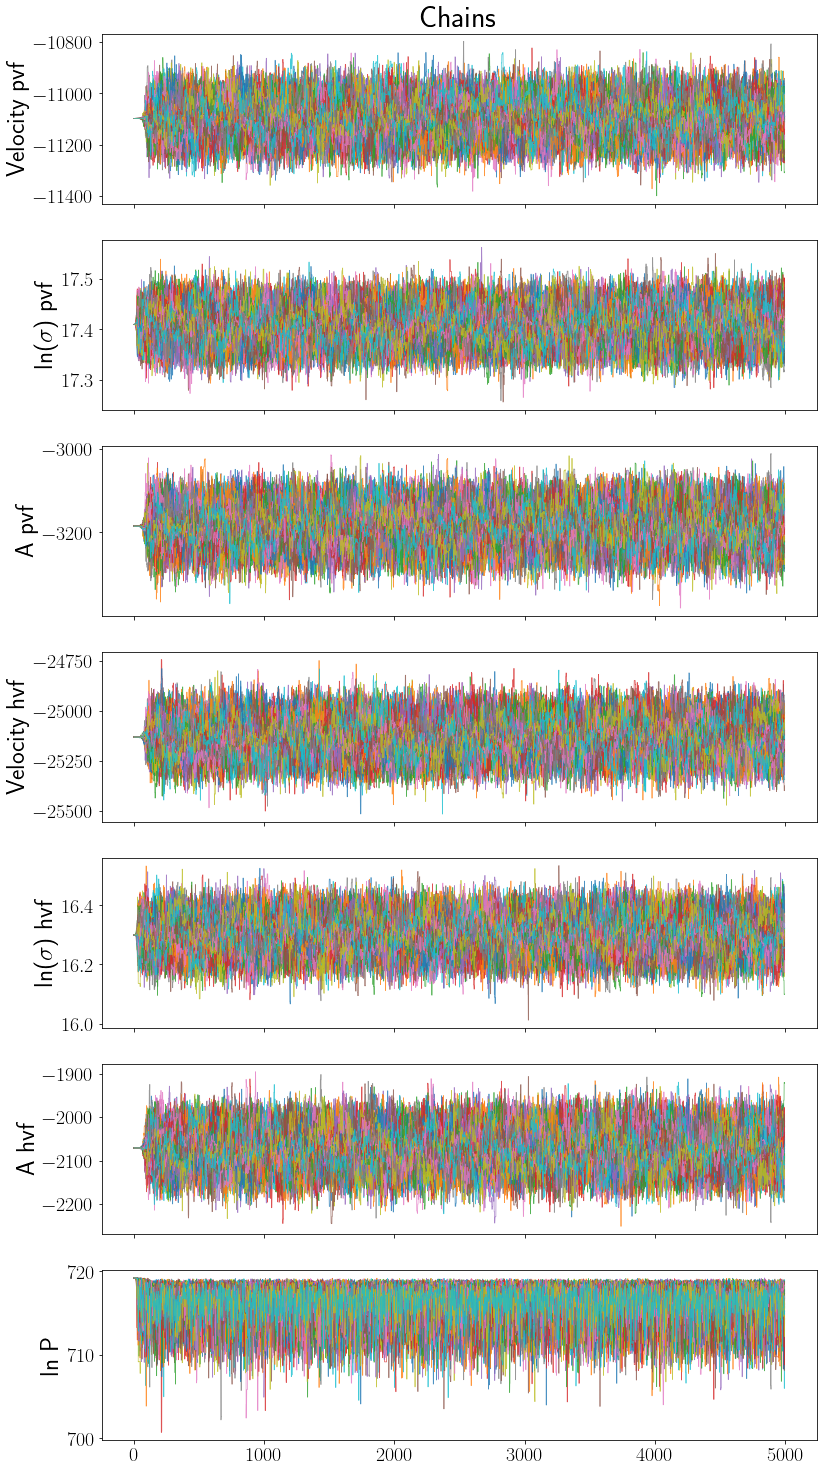

In [40]:
plotChains(sampler, 0, paramsNames)
plt.tight_layout()

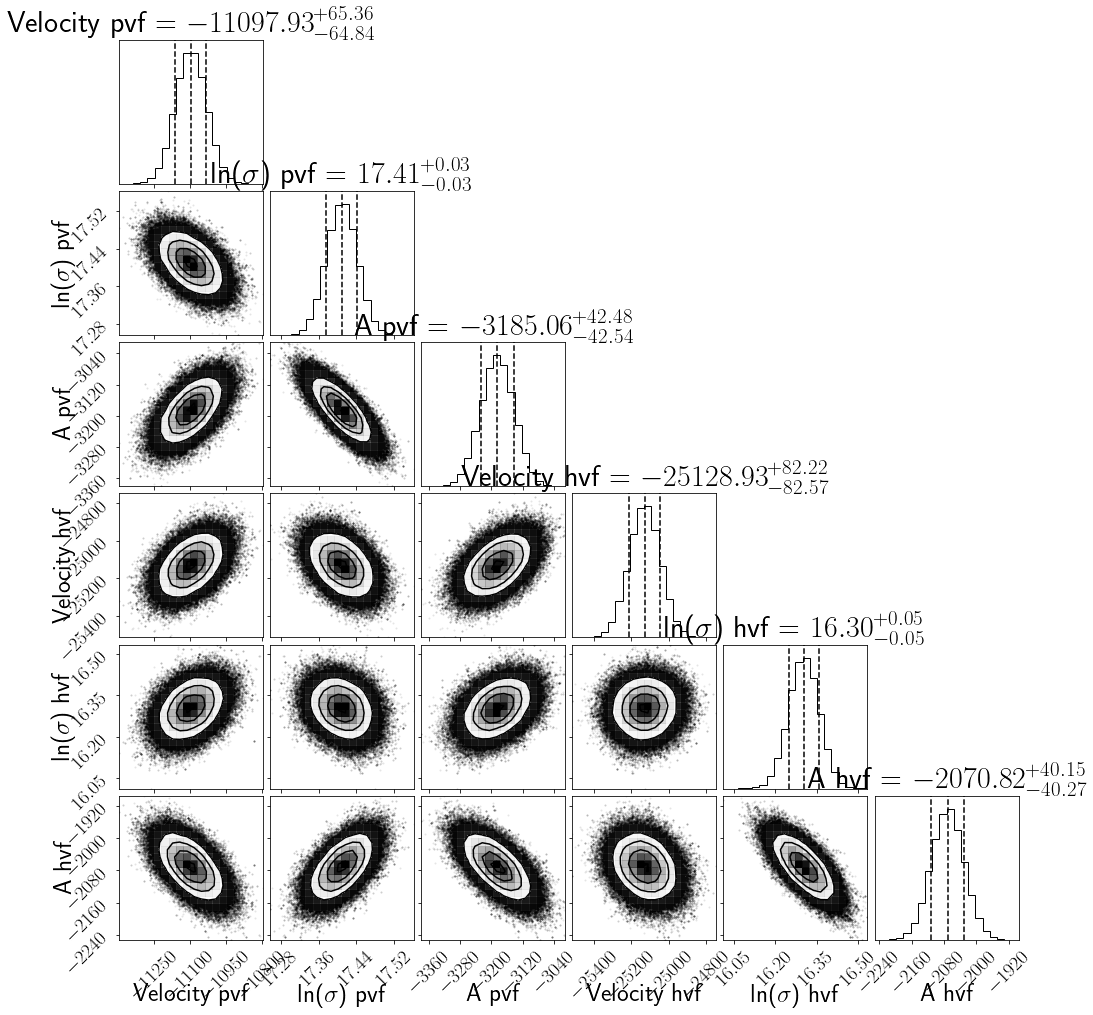

In [41]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples, 
                    labels=paramsNames, 
                    quantiles=[0.16,0.50,0.84], 
                    show_titles=True)

<ErrorbarContainer object of 3 artists>

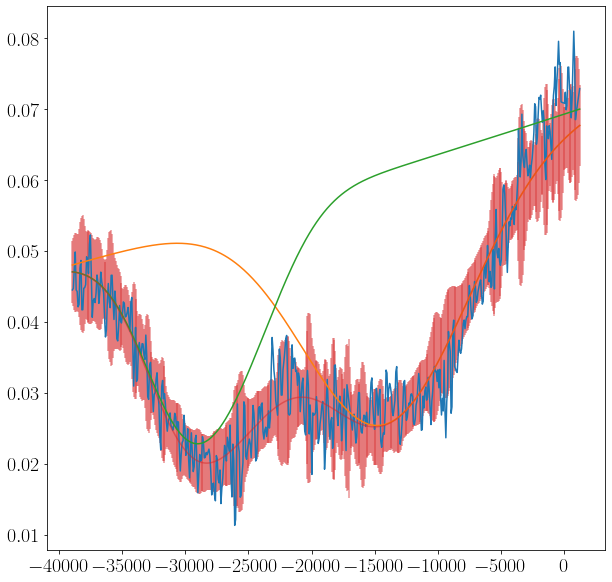

In [37]:
plt.figure(figsize=(10, 10))
plt.plot(vel_rf[line_region], norm_flux[line_region]*(k * wv_rf + b)[line_region])
plt.plot(
    vel_rf[line_region],
    flux_gauss(
        [-11098, 17.41, -3185],
        vel_rf[line_region],
        [
            velocity_rf(lambda_CaII_IRT, 8498.018),
            velocity_rf(lambda_CaII_IRT, 8542.089)  #,
            #velocity_rf(lambda_0, 8662.140)
        ]) * (k * wv_rf + b)[line_region])
plt.plot(
    vel_rf[line_region],
    flux_gauss(
        [-25130, 16.30, -2071],
        vel_rf[line_region],
        [
            velocity_rf(lambda_CaII_IRT, 8498.018),
            velocity_rf(lambda_CaII_IRT, 8542.089)  #,
            #velocity_rf(lambda_0, 8662.140)
        ]) * (k * wv_rf + b)[line_region])
plt.errorbar(
    vel_rf[line_region],
    flux_gauss(
        [-11098, 17.41, -3185, -25130, 16.30, -2071],
        vel_rf[line_region],
        [
            velocity_rf(lambda_CaII_IRT, 8498.018),
            velocity_rf(lambda_CaII_IRT, 8542.089)  #,
            #velocity_rf(lambda_0, 8662.140)
        ]) * (k * wv_rf + b)[line_region],
    yerr=norm_flux_unc[line_region] * (k * wv_rf + b)[line_region], alpha=0.5)

## Build in OOP

In [94]:
class SpectrumSN():
    '''1D optical spectrum'''
    
    def __init__(self, wave, flux, z=0, flux_unc=0):
        self.wave = wave
        self.flux = flux
        self.lambda_rf = wave/(1+z)
        self.res_dict = {}
    
    def measure_vel_and_ew(self, blue_edge, red_edge,
                           fit_region = [],
                           guess = (-10000, 15, -1000),
                           lambda_0 = 6562.85,
                           line_name = 'Halpha',
                           delta_vel = []):
        '''Measure the velocity and equivalent width'''
        
        if len(fit_region) == 0:
            fit_region = [blue_edge[0], red_edge[0]]
            
        norm_flux = divide_continuum(self.lambda_rf, self.flux, 
                                     blue_edge, red_edge)
        v_rf = velocity_rf(self.lambda_rf, lambda_0)
        line = np.where((self.lambda_rf >= fit_region[0]) & 
                        (self.lambda_rf <= fit_region[1]))
        
        vel_fit = minimize(neg_lnlike_gaussian_abs, guess, method='Powell',
                           args=(v_rf[line], norm_flux[line], delta_vel))
        v_absorb = vel_fit.x[0]
        beta = vel_fit.x[2]*(len(delta_vel)+1)/2.99792458e5
        ew = lambda_0*(1-np.sqrt((1+beta)/(1-beta)))
        
        self.res_dict[line_name] = (v_absorb, ew)
    
    def si_6355(self, blue_edge, red_edge, 
                fit_region = [],
                guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                           fit_region = fit_region,
                           guess = guess,
                           lambda_0 = 6371.37,
                           line_name = 'Si6355',
                           delta_vel = [velocity_rf(6371.359, 6347.103)])
    
    def si_5972(self, blue_edge, red_edge, 
            fit_region = [],
            guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5978.929,
                                line_name = 'Si5972',
                                delta_vel = [velocity_rf(5978.929, 5957.561)])
    def si_5669(self, blue_edge, red_edge, 
            fit_region = [],
            guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5669.562,
                                line_name = 'Si5669',
                                delta_vel = [])

    def si_5048(self, blue_edge, red_edge, 
            fit_region = [],
            guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5055.981,
                                line_name = 'Si5048',
                                delta_vel = [velocity_rf(5055.981, 5041.026)])

    def si_4130(self, blue_edge, red_edge, 
                fit_region = [],
                guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 4130.893,
                                line_name = 'Si4130',
                                delta_vel = [velocity_rf(4130.893, 4128.067)])

    def s_5500(self, blue_edge, red_edge, 
                fit_region = [],
                guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5647.033,
                                line_name = 'S5500',
                                delta_vel = [velocity_rf(5647.033, 5639.972),
                                             velocity_rf(5647.033, 5606.151),
                                             velocity_rf(5647.033, 5473.620),
                                             velocity_rf(5647.033, 5453.828),
                                             velocity_rf(5647.033, 5432.815)
                                            ])

In [95]:
minus13 = SpectrumSN(wv, fl, z=z)

In [96]:
minus13.si_6355((5830, 1.01e-14), (6288,9.84e-15))
# ,
#                 guess = (-15893.41748703,     16.70304233,  -4133.73835717))

In [97]:
minus13.res_dict

{'Si6355': (-13787.463341953779, 2715.455662209181)}

In [98]:
minus13.s_5500((5115, 1.2e-14), (5552,1.11e-14))
# ,
#                 guess = (-10000,     15.,  -1000.73835717))

In [99]:
minus13.res_dict

{'Si6355': (-13787.463341953779, 2715.455662209181),
 'S5500': (-9821.095364231103, 1271.4099391439372)}